In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
from ta.momentum import rsi
from ta.trend import macd
from tqdm import tqdm

In [2]:
START_DATE = "2023-01-01"
END_DATE = "2025-10-31"

## Getting tickers

In [3]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.reset_index(inplace=True)
stocks.head()

,Symbol,Name,Sector
0,AAPL,Apple Inc.,Information Technology
1,ABBV,AbbVie,Health Care
2,ABT,Abbott Laboratories,Health Care
3,ACN,Accenture,Information Technology
4,ADBE,Adobe Inc.,Information Technology


In [4]:
stocks['Sector'].unique()

array(['Information Technology', 'Health Care', 'Financials',
       'Real Estate', 'Consumer Discretionary', 'Industrials',
       'Consumer Staples', 'Communication Services', 'Energy',
       'Utilities', 'Materials'], dtype=object)

In [5]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Symbol  100 non-null    object
 1   Name    100 non-null    object
 2   Sector  100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


## Getting historical values

In [14]:
values = [
	yf.Ticker(stock).history(actions=False,start=START_DATE) for stock in stocks.Symbol
]
values

[                                 Open        High         Low       Close  \
 Date                                                                        
 2023-01-03 00:00:00-05:00  128.343772  128.954553  122.324579  123.211205   
 2023-01-04 00:00:00-05:00  125.004155  126.747853  123.221057  124.482033   
 2023-01-05 00:00:00-05:00  125.240575  125.871063  122.905803  123.161934   
 2023-01-06 00:00:00-05:00  124.137225  128.353606  123.033867  127.693565   
 2023-01-09 00:00:00-05:00  128.530934  131.427242  127.959553  128.215683   
 ...                               ...         ...         ...         ...   
 2026-01-05 00:00:00-05:00  270.640015  271.510010  266.140015  267.260010   
 2026-01-06 00:00:00-05:00  267.000000  267.549988  262.119995  262.359985   
 2026-01-07 00:00:00-05:00  263.200012  263.679993  259.809998  260.329987   
 2026-01-08 00:00:00-05:00  257.019989  259.290009  255.699997  259.040009   
 2026-01-09 00:00:00-05:00  259.079987  260.209991  256.220001  

In [28]:
# List to store processed dataframes
processed_list = []

for idx, stock_values in enumerate(values):
    # work on a copy to avoid SettingWithCopy warnings
    df = stock_values.copy()
    
    # 1. Log Returns (The base feature)
    # We use Log Returns because they are additive and "more" stationary than prices
    df["LogReturn"] = np.log(1 + df["Close"].pct_change())
    
    # 2. Rolling Cumulative Returns (Features)
    # Summing returns over a window is standard (Total return over 1 week, etc.)
    # Note: Do NOT multiply by the window size (e.g., *5) unless you specifically want the sum magnified.
    df["Ret_1W"] = df["LogReturn"].rolling(window=5).sum()
    df["Ret_2W"] = df["LogReturn"].rolling(window=10).sum()
    df["Ret_1M"] = df["LogReturn"].rolling(window=21).sum()
    df["Ret_2M"] = df["LogReturn"].rolling(window=42).sum()
    
    # 3. Rolling Volatility (The Normalizer)
    # We calculate std dev over a trailing window (e.g., 60 days) to capture RECENT volatility
    # This ensures NO future data is used.
    rolling_std = df["LogReturn"].rolling(window=60).std()
    
    # Handle division by zero just in case
    rolling_std = rolling_std.replace(0, np.nan)

    # 4. Apply Rolling Normalization (Z-Score)
    # This transforms the return into "How many sigmas was this move?"
    df["Norm_Ret"]    = df["LogReturn"] / rolling_std
    df["Norm_Ret_1W"] = df["Ret_1W"]    / rolling_std
    df["Norm_Ret_2W"] = df["Ret_2W"]    / rolling_std
    df["Norm_Ret_1M"] = df["Ret_1M"]    / rolling_std
    df["Norm_Ret_2M"] = df["Ret_2M"]    / rolling_std

    # 5. Other Indicators (RSI/MACD)
    # Ensure your rsi/macd functions are also strictly looking backwards
    # Normalizing RSI (0-100) to (0-1) is good practice
    if "RSI" not in df.columns: # Assuming you have the function
         df["RSI"] = rsi(df["Close"]) / 100.0
    
    # 6. Cleanup
    # Drop the first 60 rows because they will be NaN (due to the rolling window)
    df.dropna(inplace=True)
    
    # Drop raw price columns (GNNs usually struggle with raw prices)
    df.drop(columns=["Open", "High", "Low", "Volume", "Close"], errors='ignore', inplace=True)
    
    processed_list.append(df)

# Recombine into one MultiIndex DataFrame (Symbol, Date)
if processed_list:
    # keys=stocks.Symbol ensures the first index level is the Ticker
    final_values = pd.concat(processed_list, keys=stocks.Symbol)
    # Rename index levels for clarity
    final_values.index.names = ['Symbol', 'Date']
    print(final_values.head())

                                  LogReturn    Ret_1W    Ret_2W    Ret_1M  \
Symbol Date                                                                 
AAPL   2023-03-30 00:00:00-04:00   0.009841  0.021352  0.040922  0.110947   
       2023-03-31 00:00:00-04:00   0.015523  0.028604  0.061914  0.122349   
       2023-04-03 00:00:00-04:00   0.007672  0.048646  0.054221  0.095533   
       2023-04-04 00:00:00-04:00  -0.003255  0.049379  0.039093  0.073908   
       2023-04-05 00:00:00-04:00  -0.011355  0.018427  0.036883  0.077156   

                                    Ret_2M  Norm_Ret  Norm_Ret_1W  \
Symbol Date                                                         
AAPL   2023-03-30 00:00:00-04:00  0.128497  0.681142     1.477875   
       2023-03-31 00:00:00-04:00  0.135040  1.070528     1.972649   
       2023-04-03 00:00:00-04:00  0.134842  0.533939     3.385508   
       2023-04-04 00:00:00-04:00  0.095195 -0.235843     3.578206   
       2023-04-05 00:00:00-04:00  0.059733 -0.

In [29]:
final_values

LogReturn    Ret_1W    Ret_2W    Ret_1M  \
Symbol Date                                                                 
AAPL   2023-03-30 00:00:00-04:00   0.009841  0.021352  0.040922  0.110947   
       2023-03-31 00:00:00-04:00   0.015523  0.028604  0.061914  0.122349   
       2023-04-03 00:00:00-04:00   0.007672  0.048646  0.054221  0.095533   
       2023-04-04 00:00:00-04:00  -0.003255  0.049379  0.039093  0.073908   
       2023-04-05 00:00:00-04:00  -0.011355  0.018427  0.036883  0.077156   
...                                     ...       ...       ...       ...   
XOM    2026-01-05 00:00:00-05:00   0.021855  0.051142  0.072955  0.062201   
       2026-01-06 00:00:00-05:00  -0.034986  0.004305  0.036683  0.032834   
       2026-01-07 00:00:00-05:00  -0.021375 -0.020879  0.002874  0.016594   
       2026-01-08 00:00:00-05:00   0.036624  0.021131  0.028806  0.058035   
       2026-01-09 00:00:00-05:00   0.013736  0.015854  0.044218  0.052388   

                                    Ret_2M  Norm_Ret  Norm_Ret_1W  \
Symbol Date                                                         
AAPL   2023-03-30 00:00:00-04:00  0.128497  0.681142     1.477875   
       2023-03-31 00:00:00-04:00  0.135040  1.070528     1.972649   
       2023-04-03 00:00:00-04:00  0.134842  0.533939     3.385508   
       2023-04-04 00:00:00-04:00  0.095195 -0.235843     3.578206   
       2023-04-05 00:00:00-04:00  0.059733 -0.814319     1.321528   
...                                    ...       ...          ...   
XOM    2026-01-05 00:00:00-05:00  0.105807  1.899624     4.445283   
       2026-01-06 00:00:00-05:00  0.067486 -2.830484     0.348293   
       2026-01-07 00:00:00-05:00  0.050150 -1.721548    -1.681614   
       2026-01-08 00:00:00-05:00  0.079586  2.787358     1.608260   
       2026-01-09 00:00:00-05:00  0.069845  1.038266     1.198326   

                                  Norm_Ret_2W  Norm_Ret_1M  Norm_Ret_2M  \
Symbol Date                                                               
AAPL   2023-03-30 00:00:00-04:00     2.832346     7.679002     8.893725   
       2023-03-31 00:00:00-04:00     4.269850     8.437695     9.312895   
       2023-04-03 00:00:00-04:00     3.773520     6.648635     9.384389   
       2023-04-04 00:00:00-04:00     2.832813     5.355683     6.898211   
       2023-04-05 00:00:00-04:00     2.645165     5.533426     4.283908   
...                                       ...          ...          ...   
XOM    2026-01-05 00:00:00-05:00     6.341261     5.406545     9.196771   
       2026-01-06 00:00:00-05:00     2.967773     2.656381     5.459898   
       2026-01-07 00:00:00-05:00     0.231433     1.336474     4.039031   
       2026-01-08 00:00:00-05:00     2.192339     4.416883     6.057118   
       2026-01-09 00:00:00-05:00     3.342229     3.959718     5.279207   

                                       RSI  
Symbol Date                                 
AAPL   2023-03-30 00:00:00-04:00  0.669896  
       2023-03-31 00:00:00-04:00  0.702586  
       2023-04-03 00:00:00-04:00  0.717643  
       2023-04-04 00:00:00-04:00  0.701385  
       2023-04-05 00:00:00-04:00  0.646740  
...                                    ...  
XOM    2026-01-05 00:00:00-05:00  0.707995  
       2026-01-06 00:00:00-05:00  0.556495  
       2026-01-07 00:00:00-05:00  0.489494  
       2026-01-08 00:00:00-05:00  0.582874  
       2026-01-09 00:00:00-05:00  0.612251  

[69800 rows x 11 columns]

In [20]:
final_values.reset_index(inplace=True)

## Handling missing values

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# 1. Pivot the data to make it a matrix (Index=Date, Columns=Stock)
# Replace 'Close' with whatever price column you have (e.g. 'Adj Close')
# If you have duplicates, you might need to use pivot_table instead
df_pivot = final_values.pivot(index='Date', columns='Symbol', values='LogReturn')

# 2. Check for Missing Values (NaN)
missing_counts = df_pivot.isnull().sum()
print("--- Missing Days per Stock ---")
print(missing_counts[missing_counts > 0]) # Only show stocks with missing data

# 3. Check for Total Completeness
total_expected = df_pivot.shape[0] # Total unique trading days found
print(f"\nTotal unique trading days found: {total_expected}")

# If a stock has count < total_expected, it is missing days
valid_stocks = missing_counts[missing_counts == 0]
print(f"Number of complete stocks: {len(valid_stocks)} out of {len(df_pivot.columns)}")

--- Missing Days per Stock ---
Series([], dtype: int64)

Total unique trading days found: 698
Number of complete stocks: 100 out of 100


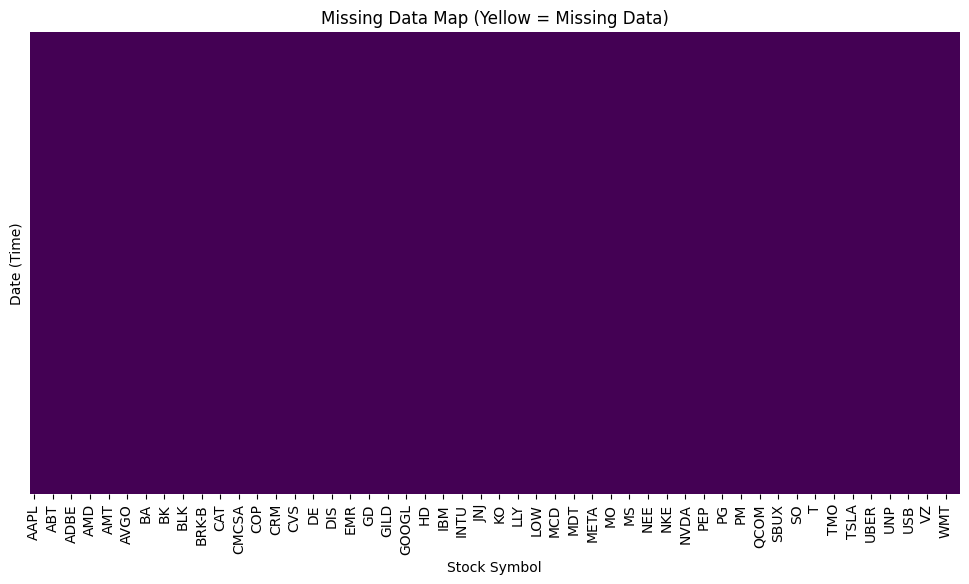

In [23]:
plt.figure(figsize=(12, 6))

# We use .isnull() to turn the data into True/False (True = Missing)
# cbar=False turns off the color bar to keep it clean
sns.heatmap(df_pivot.isnull(), cbar=False, yticklabels=False, cmap='viridis')

plt.title("Missing Data Map (Yellow = Missing Data)")
plt.xlabel("Stock Symbol")
plt.ylabel("Date (Time)")
plt.show()

In [25]:
# Create a range of all business days (Monday-Friday) in your interval
all_weekdays = pd.date_range(start="2023-01-01", end="2025-10-30", freq="B")

# Identify which weekdays are completely missing from your dataset
# (Note: This will list Market Holidays like Christmas, which is normal)
dates_in_data = pd.to_datetime(prepared_values['Date'].unique())
missing_dates = all_weekdays.difference(dates_in_data)

print(f"Weekdays with NO data (includes holidays): {len(missing_dates)}")
print(missing_dates[:10]) # Print first 10

Weekdays with NO data (includes holidays): 739
DatetimeIndex(['2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11',
               '2023-01-12', '2023-01-13'],
              dtype='datetime64[ns]', freq='B')


In [35]:
df = pd.read_csv("data/values.csv")
df.head()

,Symbol,Date,LogReturn,Ret_1W,Ret_2W,Ret_1M,Ret_2M,Norm_Ret,RSI,MACD
0,AAPL,2023-03-30 00:00:00-04:00,0.009841,1.477866,2.832367,7.679009,8.893742,0.681144,0.669896,3.219354
1,AAPL,2023-03-31 00:00:00-04:00,0.015523,1.972666,4.269886,8.437749,9.312944,1.070556,0.702587,3.525152
2,AAPL,2023-04-03 00:00:00-04:00,0.007672,3.385522,3.773534,6.648656,9.384401,0.533927,0.717643,3.824519
3,AAPL,2023-04-04 00:00:00-04:00,-0.003255,3.578208,2.832828,5.355683,6.898200,-0.235864,0.701385,3.972981
4,AAPL,2023-04-05 00:00:00-04:00,-0.011354,1.321539,2.645186,5.533448,4.283927,-0.814308,0.646740,3.896840


In [36]:
df.tail()

,Symbol,Date,LogReturn,Ret_1W,Ret_2W,Ret_1M,Ret_2M,Norm_Ret,RSI,MACD
69795,XOM,2026-01-05 00:00:00-05:00,0.021855,4.445283,6.341261,5.406545,9.196771,1.899624,0.707995,1.628888
69796,XOM,2026-01-06 00:00:00-05:00,-0.034986,0.348293,2.967773,2.656381,5.459898,-2.830484,0.556495,1.553109
69797,XOM,2026-01-07 00:00:00-05:00,-0.021375,-1.681614,0.231433,1.336474,4.039031,-1.721548,0.489494,1.271821
69798,XOM,2026-01-08 00:00:00-05:00,0.036624,1.608260,2.192339,4.416883,6.057118,2.787358,0.582874,1.389539
69799,XOM,2026-01-09 00:00:00-05:00,0.013736,1.198326,3.342229,3.959718,5.279207,1.038266,0.612251,1.601545
